<a href="https://colab.research.google.com/github/weymouth/NumericalPython/blob/main/05SciPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scientific Python

We've now had a few good examples of using NumPy for engineering computing and PyPlot for visualization. In this notebook we will introduce the *Scientific Python* or [SciPy library](https://www.scipy.org/scipylib/index.html). While the NumPy library has an extensive set of methods for array operations, SciPy focuses on numerical methods for common mathematical and scientific problems such as:

| Category          | Sub module        | Description                                            |
|-------------------|-------------------|--------------------------------------------------------|
| Interpolation     | scipy.interpolate | Numerical interpolation of 1D and multivariate data    |
| Optimization      | scipy.optimize    | Function optimization, curve fitting, and root finding |
| Integration       | scipy.integrate   | Numerical integration quadratures and ODE integrators  |
| Signal processing | scipy.signal      | Signal processing methods                              |
| Special functions | scipy.special     | Defines transcendental functions such as $J_n$ and $\Gamma$|
<span style="display:none"></span>

This notebook won't attempt to go through all of the important numerical methods in SciPy - for that you can read the [SciPy book](http://scipy-lectures.org/intro/scipy.html). It also won't attempt to be a class in numerical methods. Instead this notebook will simply illustrate the use of a SciPy with a few engineering applications.

---

## Ordinary Differential Equations

Ordinary Differential Equations (ODEs) are ubiquitous in engineering and dynamics, and numerical methods are excellent at producing high-quality approximate solutions to ODEs that can't be solved analytically. 

As a warm up, the function $y=e^{t}$  is an exact solution of the initial value problem (IVP)

$$ \frac{dy}{dt} = y \quad\text{with}\quad y(0) = 1 $$

SciPy has a few functions to solve IVPs, but I like `solve_ivp` the best. Let's check it out.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

?solve_ivp

So the first argument is the ODE function, the right hand side, then the span over which we want to integrate, and then the initial condition. Let's try it.

In [2]:
fun = lambda t,y: y  # lambda function syntax
y0 = [1]
t_span = [0,2]
sol = solve_ivp(fun, t_span, y0)
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.10001999, 1.06609106, 2.        ])
 t_events: None
        y: array([[1.        , 1.10519301, 2.9040598 , 7.38932547]])
 y_events: None

So the function outputs a bunch of useful information about what happened. Also note the times is stored in a 1D array `sol.t` and the solution is stored in a 2D array (more on that later). Let's plot this up.

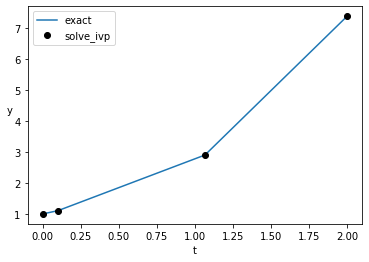

In [3]:
plt.plot(sol.t,np.exp(sol.t),label='exact')
plt.plot(sol.t,sol.y[0],'ko',label='solve_ivp')
plt.xlabel('t')
plt.ylabel('y',rotation=0)
plt.legend();

First off, the numerical method matches the exact solution extremely well. But this plot seems a little weird. The solver used a small time step at first (`t[1]-t[0]=0.1`) and then took bigger steps (`t[3]-t[2]=0.99`). This is because the solver uses an [adaptive 4th order Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method) to integrate by default, which adjusts the time step to get the highest accuracy for the least number of function evaluations.

That's great, but we want the results at a more regular interval for plotting, and the argument `t_eval` lets us do that: 

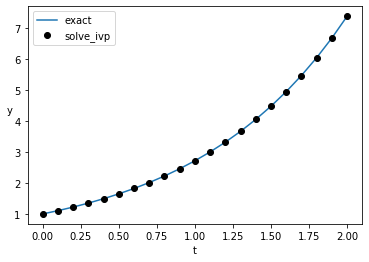

In [4]:
t = np.linspace(0,2,21)
y_sol = solve_ivp(fun, t_span = [t[0],t[-1]] , y0 = y0, t_eval = t).y[0]

plt.plot(t,np.exp(t),label='exact')
plt.plot(t,y_sol,'ko',label='solve_ivp')
plt.xlabel('t')
plt.ylabel('y',rotation=0)
plt.legend();

Much better and we can see the accuracy is still excellent - it just took a few more evaluations.

---

That's nice, but most engineering systems are more complex than first order ODEs. For example, even a forced spring-mass-damper systems is second order:

$$ m \frac{d^2 x}{dt^2} + c \frac{dx}{dt} + k x = f(t) $$ 

But it is actually very simple to deal with this additional derivative, we just define the position and velocity as two separate variables, the *states* of the oscillator:

$$ y = \left[x,\ \frac{dx}{dt}\right] $$

And therefore

$$ \frac{dy}{dt} = \left[ \frac{dx}{dt},\ \frac{d^2x}{dt^2}\right] = \left[y[1],\ \frac{f(t)-c y[1] - k y[0]}{m} \right] $$ 

This trick can reduce any ODE of order `m` down to system of `m` states all governed by first order ODEs. `solve_ivp` assumes `y` is a 2D array of these states since it is the standard way to deal with dynamical systems. 

Let's try it on this example.

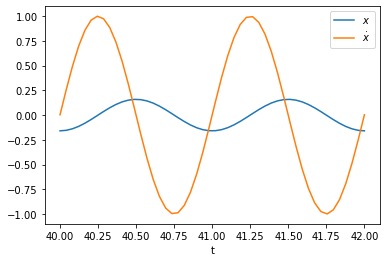

In [5]:
# define forcing, mass-damping-stiffness, and ODE
f = lambda t: np.sin(2*np.pi*t)
m,c,k = 1,1,(2*np.pi)**2
linear = lambda t,y: [y[1],(f(t)-c*y[1]-k*y[0])/m]

# adaptive step to t=40 to research steady state
y = solve_ivp(linear,[0,40],[0,0]).y

# integrate another couple cycles for plotting
t = np.linspace(40,42)
y = solve_ivp(linear,[t[0],t[-1]],y[:,-1], t_eval=t).y

plt.plot(t,y[0],label='$x$')
plt.plot(t,y[1],label='$\dot x$')
plt.xlabel('t')
plt.legend();

This gives a sinusoid, as expected but is it correct? Instead of using the exact solution (available in this case but not generally), let's *sanity check* the results based on physical understanding. **You should always do this when using numerical methods!**

 - If we could ignore dynamics, the expected deflection would simply be $x=f/k$. Since the magnitude of $f=1$ and $k=(2\pi)^2$ this would mean we would have an amplitude of $x\sim (2\pi)^{-2} \approx 0.025$. Instead we see an amplitude $x=0.4$! Is this reasonable??
 - The natural frequency given the parameters above is $\omega_n = \sqrt(k/m) = 2\pi$. The force is *also* being applied at a frequency of $2\pi$. This could explain the high amplitude - our spring-mass system is in resonance!
 
Since we have an idea to explain our results - it is your turn to test it out:
 1. Lower the forcing frequency x10. This should reduce the influence of dynamics and we should see amplitudes similar to our prediction. 
 2. Reset the frequency and increase the mass x10. Predict what this should do physically before running the simulation. Do the results match your predictions?
 

Finally, one of the main advantages of the numerical approach to ODEs is that they extend trivially to nonlinear equations. For example, using a nonlinear damping $c\dot x \rightarrow d \dot x|\dot x|$ makes the dynamics difficult to solve analytically, but requires no change to our approach, only an updated ODE:

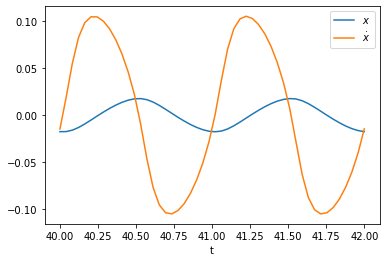

In [6]:
# define nonlinear damped ODE
d = 100
nonlinear = lambda t,y: [y[1],(f(t)-d*y[1]*abs(y[1])-k*y[0])/m]

y = solve_ivp(nonlinear,[0,40],[0,0]).y
t = np.linspace(40,42)
y = solve_ivp(nonlinear,[t[0],t[-1]],y[:,-1], t_eval=t).y

plt.plot(t,y[0],label='$x$')
plt.plot(t,y[1],label='$\dot x$')
plt.xlabel('t')
plt.legend();

## Root finding and implicit equations

Another ubiquitous problem in engineering is *root finding*; determining the arguments which make a function zero. As before, there are a few SciPy routines for this, but `fsolve` is a good general purpose choice. Let's check it out.

In [7]:
from scipy.optimize import fsolve

?fsolve

So `fsolve` also takes a function as the first argument, and the second argument is the starting point `x0` of the search for the root. 

As before, let's start with a simple example, say $\text{func}=x\sin x$ which is zero at $x=n\pi$ for $n=0,1,2,\ldots$.

In [8]:
func = lambda x: x*np.sin(x)

for x0 in range(1,8,2):
    print(x0,fsolve(func,x0))

1 [4.34377151e-84]
3 [3.14159265]
5 [15.70796327]
7 [6.28318531]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


This example shows that a root finding method needs to be used with care when there is more than one root. Here we get different answers depending on `x0` and it's sometimes surprising; `x0=5` found the root at $5\pi$ instead of $2\pi$. Something to keep in mind.

Root finding methods are especially useful for dealing with implicit equations. For example, the velocity of fluid through a pipe depends on the fluid friction, but this friction is itself a function of the flow velocity. The [semi-emperical equation](https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae#Colebrook%E2%80%93White_equation) for the Darcy friction factor $f$ is

$$ \frac 1 {\sqrt f}  = -2\log_{10}\left(\frac \epsilon{3.7 D}+ \frac{2.51}{Re \sqrt f} \right)$$ 

where $\epsilon/D$ is the pipe wall roughness to diameter ratio, $Re=UD/\nu$ is the diameter-based Reynolds number, and the coefficients are determined from experimental tests. 

Directly solving this equation for $f$ is difficult, and engineers use charts like the [Moody Diagram](https://en.wikipedia.org/wiki/Moody_chart#/media/File:Moody_EN.svg) instead. But this is simple to solve with a root finding method; we just need to express this as function which is zero at the solution and this is always possible by simply subtracting the right-hand-side from the left!

$$ \text{func} = \frac 1 {\sqrt f} + 2\log_{10}\left(\frac \epsilon{3.7 D}+ \frac{2.51}{Re \sqrt f} \right)$$ 

which is zero when $f$ satisfies our original equation.

In [9]:
# @np.vectorize
def darcy(Re,eps_D,f0=0.03):
    func = lambda f: 1/np.sqrt(f)+2*np.log10(eps_D/3.7+2.51/(Re*np.sqrt(f)))
    return fsolve(func,f0)[0]

darcy(1e6,1e-3)

array(0.01994347)

Notice we have defined one function *inside* another. This lets us define $Re$ and $\epsilon/D$ as *arguments* of `darcy`, while being *constants* in `func`. There are other ways to parameterize a rooting finding approach, but I like this approach because the result is a function (like `darcy`) which behaves exactly like an explicit function (in this case, for $f$). 

This matches the results in the Moody Diagram, and in fact, we should be able to make our own version of the diagram to test it out fully:

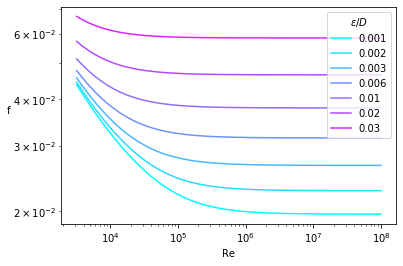

In [10]:
Re = np.logspace(3.5,8)
for i,eps_D in enumerate(np.logspace(-3,-1.5,7)):
    f = darcy(Re,eps_D)
    plt.loglog(Re,f, label='{:.1g}'.format(eps_D), color=plt.cm.cool(i/7))
plt.xlabel('Re')
plt.ylabel('f',rotation=0)
plt.legend(title='$\epsilon/D$',loc=1);

Uh oh - this didn't work. Remember how functions such as `np.sin` *broadcast* the function across an array of arguments by default. Well, `fsolve` doesn't broadcast by default, so we need to do it ourselves. 

Luckily, this is trivial using [decorators](https://docs.python.org/3/library/functools.html). Decorators are a neat python feature which lets you add capabilities to a function without coding them yourself. There are tons of useful examples (like adding a `@cache` to avoid repeating expensive calculations) but the one we need is `@np.vectorize`. Uncomment that line above the function definition and run that block again - you should see that the output is now an array. Now try running the second code cell and you should see our version of the Moody Diagram. 

Notice I've used `np.logspace` to get logarithmically spaced points, `plt.loglog` to make a plot with log axis in both x and y, and `plt.cm.cool` to use a [sequential color palette](https://medium.com/nightingale/how-to-choose-the-colors-for-your-data-visualizations-50b2557fa335) instead of the PyPlot default. Use the help features to look up these functions for details.

Your turn:
 1. Write a function to solve the equation $r^{4}-2r^{2}\cos 2\theta = b^{4}-1$ for $r$. Test that your function gives $r=\sqrt{2}$ when $b=1$ and $\theta=0$.
 2. Reproduce a plot of the [Cassini ovals](https://en.wikipedia.org/wiki/Cassini_oval) using this function. 
 
*Hint:* Define `theta=np.linspace(0,2*np.pi)`, use `@np.vectorize`, and use `plt.polar` or convert $r,\theta \rightarrow x,y$ using the method in [notebook 3]().*

## Blasius boundary layer

As a last example, I want to show how you can **combine** these two techniques to solves a truly hard engineering equation with just a couple lines of code. Dividing complex problems down to pieces that you can solve with simple methods and combining them back together to obtain the solution is the secret sauce of programming and well worth learning. 

The governing equations for viscous fluids are very difficult to deal with, both [mathematically](https://www.claymath.org/millennium-problems/navier%E2%80%93stokes-equation) and [numerically](https://en.wikipedia.org/wiki/Turbulence_modeling). But these equations can be simplified in the case of a laminar flow along a flat plate. In this case we expect the velocity $u=0$ on the plate because of friction, but then to rapidly increase up to an asymptotic value $u\rightarrow U$. 

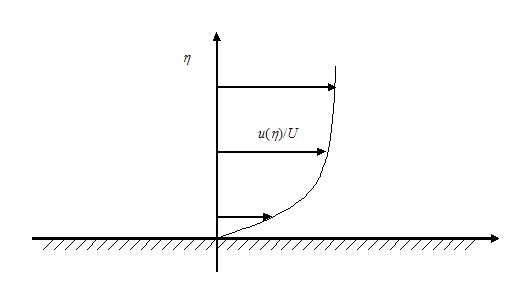

This thin region of slowed down flow is called the boundary layer and we want to predict the shape of the *velocity profile* in this region. The [Blasius equation](https://en.wikipedia.org/wiki/Blasius_boundary_layer) governs this shape:

$$ A'''+\frac 12 A A'' = 0 $$

where $A'(z) = u/U$ is the scaled velocity function and $z$ is the scaled distance from the wall. The function $A$ has the boundary conditions

$$ A(0) = A'(0) = 0 \quad\text{and}\quad A'(\infty) = 1 $$

This equation is still too complex to solve analytically, and it might looked to hard numerically as well. But we just need to take it one step at a time.

### Step 1:

We can reduce the Blasius equation to a first order ODE as before by defining 

$$ y = \left[A,\ A',\ A'' \right],\quad y' = \left[y[1],\ y[2],\ -\frac 12 y[0]y[2] \right] $$

Notice `y[1]`=$u/U$ is our goal, the velocity profile.

But to use `solve_ivp` we also need our initial conditions. We don't know $A''(0)=$`C0`, but *if we did* the initial condition would be `y0 = [0,0,C0]` and we could solve for the profile:

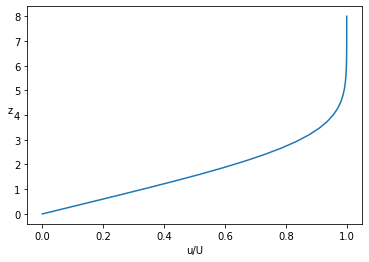

In [18]:
def blasius(t,C0):
    return solve_ivp(lambda t,y: [y[1],y[2],-0.5*y[0]*y[2]], [t[0],t[-1]], [0,0,C0], t_eval = t).y[1]

C0 = 1 # guess
# C0 = fsolve(lambda C0: blasius(range(11),C0)[-1]-1,x0=1)[0] # solve!

z = np.linspace(0,8,31)
plt.plot(blasius(z,C0),z)
plt.xlabel('u/U')
plt.ylabel('z',rotation=0);

### Step 2

We can determine `C0` using the addition boundary condition, $A'(\infty)=1$. It is hard to deal with infinity numerically, but we see in the plot above that the profile is pretty much constant for z>4 anyway, so we'll just apply this condition to the last point, ie `blasius(C0)[-1]=1`. This is an implicit equation for `C0`, and we can solve it using `fsolve` as we did above: we simply substract the right-hand-side and define `func = blasius(C0)[-1]-1` which is zero when `C0` satisfies the boundary condition. Uncomment the line in the code block above to check that it works.

The value of `C0` is actually physically important as well - it's related to the friction coefficient, and we have that value 
as well:

In [17]:
print("Blasius c_f sqrt(Re) = {:.3f}".format(2*C0))

Blasius c_f sqrt(Re) = 0.664


So $c_f \sqrt{Re_x} = 0.664$ for a laminar boundary layer. 

And just like that, we're done. We've numerically solved the Blasius equation in around two lines of code; determining one of the very few exact solutions for nonlinear flows in engineering and come up with a practical friction coefficient that we can use to determine the drag on immersed bodies. Not too shabby.